# IY011: Variation Experiments (Varying 1 Stat)

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import pandas as pd
from utils.data_loader import baseline_data_prep
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================================
# CONFIGURATION
# ==========================================
# Adjust these paths to match your actual experiment folders/CSVs
EXPERIMENTS = [
    {
        "name": "1. Baseline (Sobol)",
        "data_dir": "data",
        "csv_name": "IY011_simulation_parameters_sobol.csv",
        "color": "black"
    },
    {
        "name": "2. Mu Variation",
        # "data_dir": "temp_data_mu_variation",
        "data_dir": "data_mu_variation",
        "csv_name": "IY011_simulation_mu_parameters_sobol.csv",
        "color": "blue"
    },
    {
        "name": "3. CV Variation",
        # "data_dir": "temp_data_cv_variation",
        "data_dir": "data_cv_variation",
        "csv_name": "IY011_simulation_cv_parameters_sobol.csv",
        "color": "green"
    },
    {
        "name": "4. Tac Variation",
        # "data_dir": "temp_data_t_ac_variation",
        "data_dir": "data_t_ac_variation",
        "csv_name": "IY011_simulation_t_ac_parameters_sobol.csv",
        "color": "red"
    }
]


# check that each dataset has the expected stats

In [3]:
def plot_obs_vs_target(ax, df, target_col, obs_col, title, color):
    """Helper to create a single scatter plot with y=x line."""
    if target_col not in df.columns or obs_col not in df.columns:
        ax.text(0.5, 0.5, f"Column missing:\n{target_col} or {obs_col}", 
                ha='center', va='center', transform=ax.transAxes)
        return

    # Scatter Plot
    ax.scatter(df[target_col], df[obs_col], alpha=0.5, marker='.', color=color)
    
    # Identity Line (y=x)
    min_val = min(df[target_col].min(), df[obs_col].min())
    max_val = max(df[target_col].max(), df[obs_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y=x)', linewidth=1.5)
    
    # Aesthetics
    ax.set_xlabel(f'{title} Target')
    ax.set_ylabel(f'{title} Observed')
    ax.set_title(f'{title} Accuracy')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()

Loading results for: 1. Baseline (Sobol)...


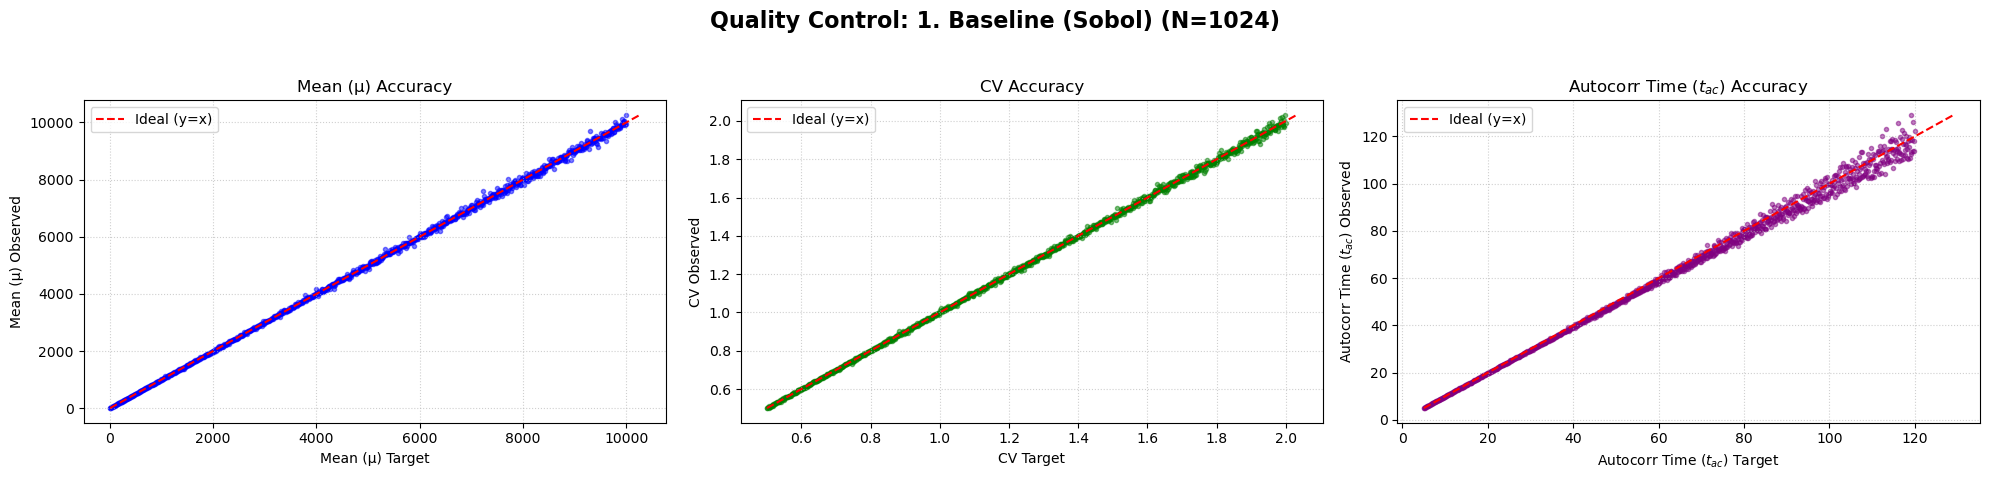

Loading results for: 2. Mu Variation...


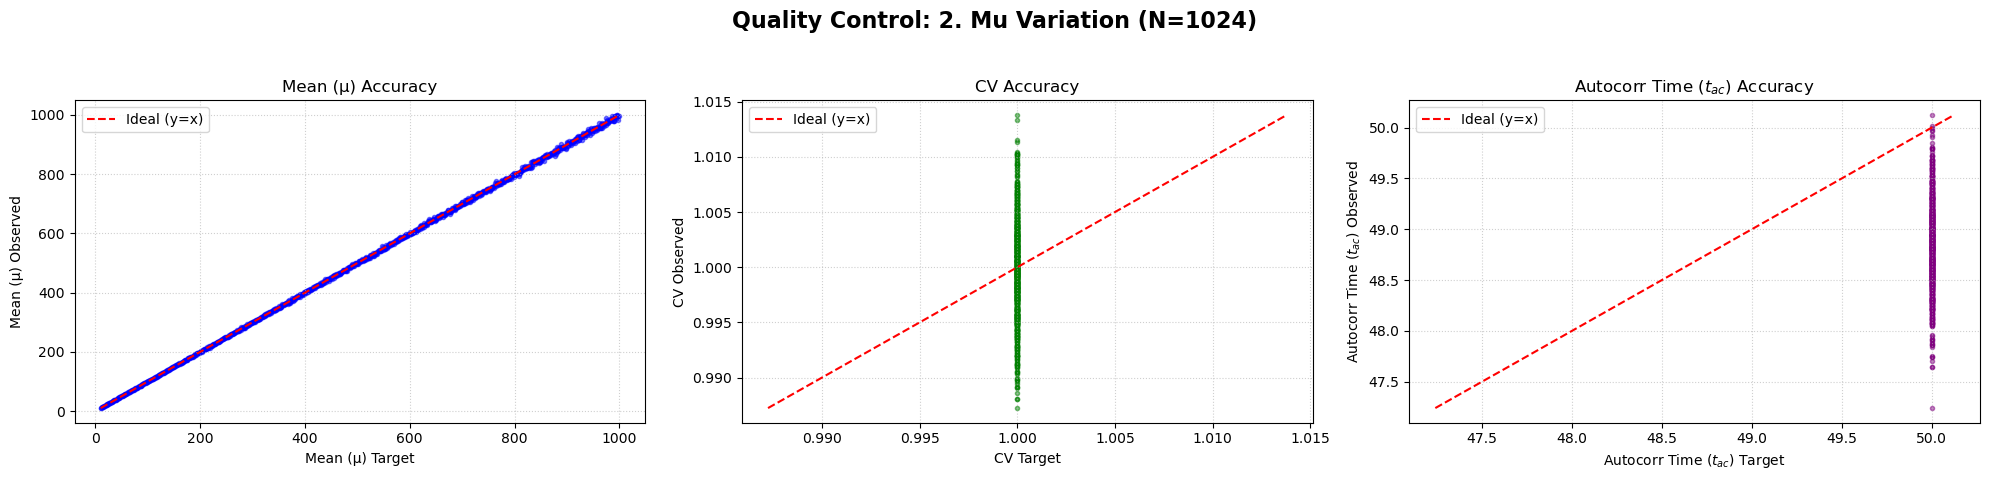

Loading results for: 3. CV Variation...


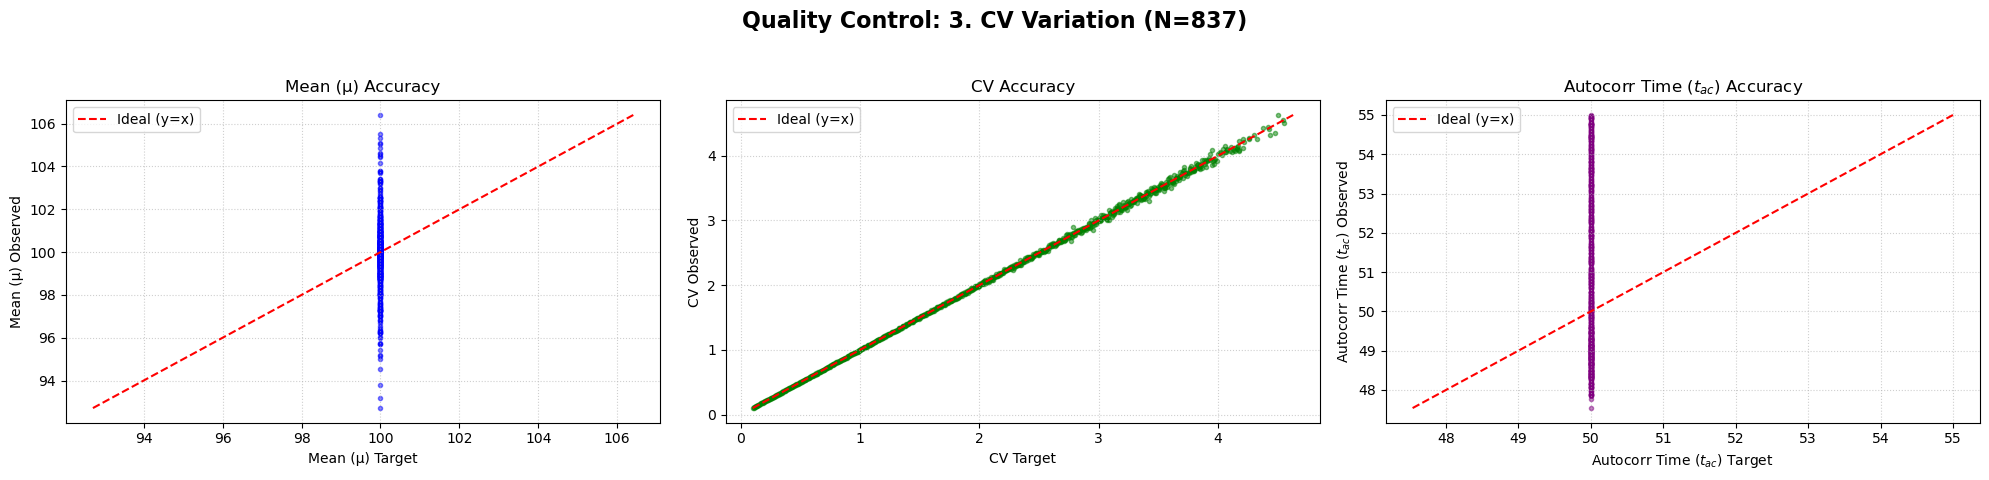

Loading results for: 4. Tac Variation...


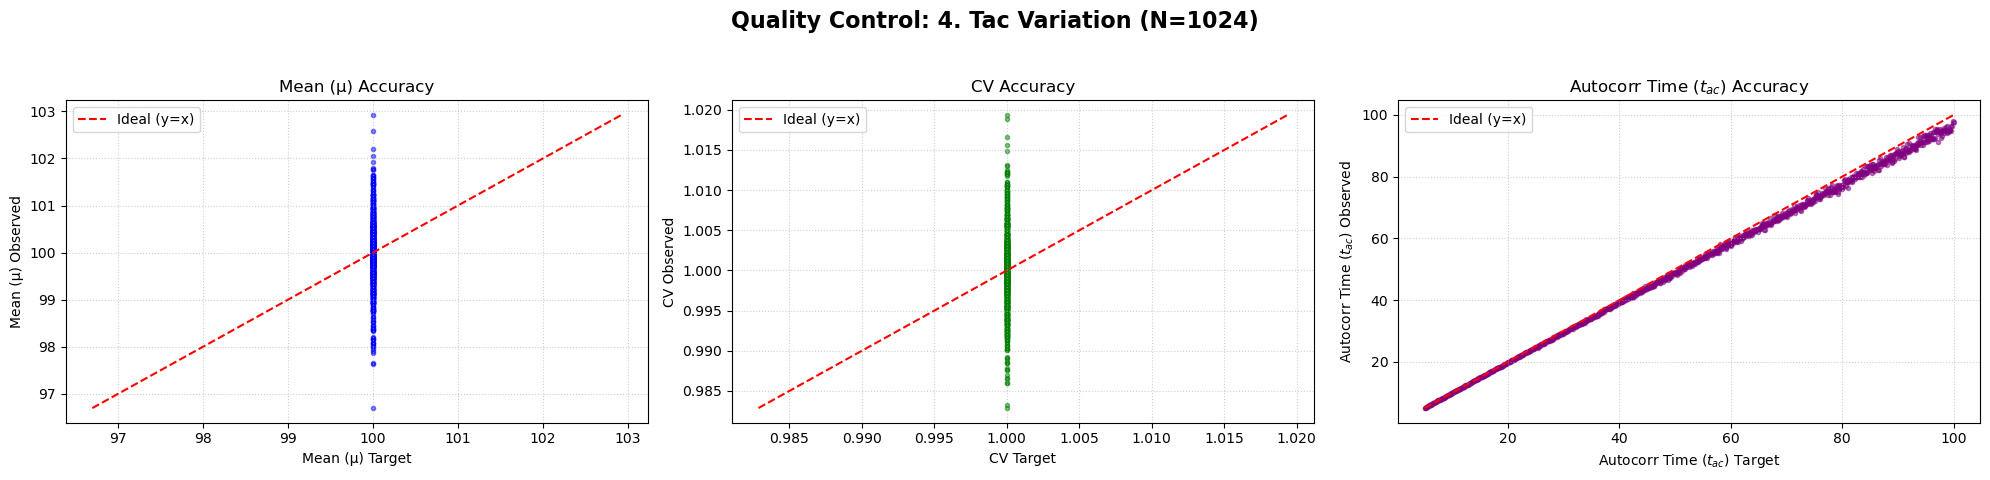

In [4]:
script_dir = Path.cwd() # Current working directory (works best in Notebooks)

for exp in EXPERIMENTS:
    csv_path = script_dir / exp["data_dir"] / exp["csv_name"]
    
    if not csv_path.exists():
        print(f"⚠️ Skipping {exp['name']}: File not found at {csv_path}")
        continue

    print(f"Loading results for: {exp['name']}...")
    try:
        df = pd.read_csv(csv_path)
        # filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
        df = df[(df['success'] == True) & 
                            (df['error_message'].isna()) &
                            (df['mean_rel_error_pct'] < 10) & 
                            (df['cv_rel_error_pct'] < 10) & 
                            (df['t_ac_rel_error_pct'] < 10)]
        
        # Create a figure with 3 subplots (Mu, CV, Tac)
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        fig.suptitle(f"Quality Control: {exp['name']} (N={len(df)})", fontsize=16, weight='bold')

        # 1. Plot Mu
        plot_obs_vs_target(axes[0], df, 'mu_target', 'mu_observed', 'Mean (μ)', 'blue')

        # 2. Plot CV
        plot_obs_vs_target(axes[1], df, 'cv_target', 'cv_observed', 'CV', 'green')

        # 3. Plot Tac
        plot_obs_vs_target(axes[2], df, 't_ac_target', 't_ac_observed', 'Autocorr Time ($t_{ac}$)', 'purple')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
        plt.show()
        
    except Exception as e:
        print(f"❌ Error processing {exp['name']}: {e}")

# visualise each dataset (after instance norm) to see differences

In [5]:
def visualize_batch(loader, exp_name, color):
    """
    Fetches one batch and plots samples from it.
    """
    try:
        # Fetch one batch
        X, y = next(iter(loader)) 
        # X shape: (Batch, Total_Time, 1)
        # y shape: (Batch, 1)
    except StopIteration:
        print(f"⚠️ Could not load batch for {exp_name}")
        return

    print(f"\n=== Visualizing: {exp_name} ===")
    print(f"Batch Shape: {X.shape}")
    print(f"Batch Stats -> Mean: {X.mean():.4f} | Std: {X.std():.4f} (Should be ~0.0 and ~1.0)")

    # Plot 4 samples
    fig, axes = plt.subplots(2, 4, figsize=(14, 8), sharex=True, sharey=True)
    fig.suptitle(f"{exp_name}\n(Instance Norm + Concatenation)", fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        if i >= len(X): break
        
        traj = X[i].flatten().numpy()
        label = y[i].item()
        
        # 1. Plot the Time Series
        ax.plot(traj, color=color, linewidth=0.8, alpha=0.8)
        
        # 2. Add visual aid for stats
        mean_val = traj.mean()
        std_val = traj.std()
        
        # Title with metadata
        label_str = "POSITIVE (Same)" if label == 1.0 else "NEGATIVE (Diff)"
        ax.set_title(f"Sample {i}: {label_str}\n$\mu$={mean_val:.2f}, $\sigma$={std_val:.2f}", fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # 3. Highlight the Zero line (since it's normalized)
        ax.axhline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # 4. Plot Histograms (Density) to see the "Shape" of the signal values
    plt.figure(figsize=(10,8))
    for i in range(8):
        sns.kdeplot(X[i].flatten().numpy(), color=color, alpha=i*0.1, fill=True, label=f"Sample {i}")
    plt.title(f"Value Distribution (Density) - {exp_name}")
    plt.xlabel("Normalized Intensity Value (Sigma)")
    plt.axvline(0, color='black', linestyle='--')
    plt.legend()
    plt.show()

Loading data for 1. Baseline (Sobol)...
Files split: 655 Train, 164 Val, 205 Test
Generating 10 training groups...


  0%|          | 0/10 [00:00<?, ?it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_7313.901_1.028_12.552.npz
 B: mRNA_trajectories_9606.290_1.932_80.735.npz


 20%|██        | 2/10 [00:00<00:02,  3.92it/s]

Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_5530.242_1.939_31.594.npz
 B: mRNA_trajectories_6697.291_1.106_46.868.npz


 40%|████      | 4/10 [00:01<00:01,  3.39it/s]

Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_7812.415_1.015_36.226.npz
 B: mRNA_trajectories_9152.688_0.608_13.854.npz


 50%|█████     | 5/10 [00:01<00:01,  2.84it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_8451.545_1.542_119.383.npz
 B: mRNA_trajectories_8145.629_0.720_84.335.npz


 60%|██████    | 6/10 [00:02<00:01,  2.95it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_2410.649_0.644_55.682.npz
 B: mRNA_trajectories_3238.956_1.290_86.243.npz


 80%|████████  | 8/10 [00:02<00:00,  3.63it/s]

Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_1595.980_0.999_48.396.npz
 B: mRNA_trajectories_5762.098_0.863_106.273.npz


 90%|█████████ | 9/10 [00:02<00:00,  3.65it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_8187.457_1.848_56.798.npz
 B: mRNA_trajectories_9379.667_1.754_11.791.npz


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Generating validation groups...


  0%|          | 0/1 [00:00<?, ?it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_3967.237_1.581_79.933.npz
 B: mRNA_trajectories_7923.384_1.824_82.352.npz


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Generating test groups...


  0%|          | 0/1 [00:00<?, ?it/s]

Generating POSITIVE group.


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Batch Mean (should be ~0): -0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -1.40, Max Value: 9.59

=== Visualizing: 1. Baseline (Sobol) ===
Batch Shape: torch.Size([8, 3623, 1])
Batch Stats -> Mean: 0.0000 | Std: 0.9999 (Should be ~0.0 and ~1.0)


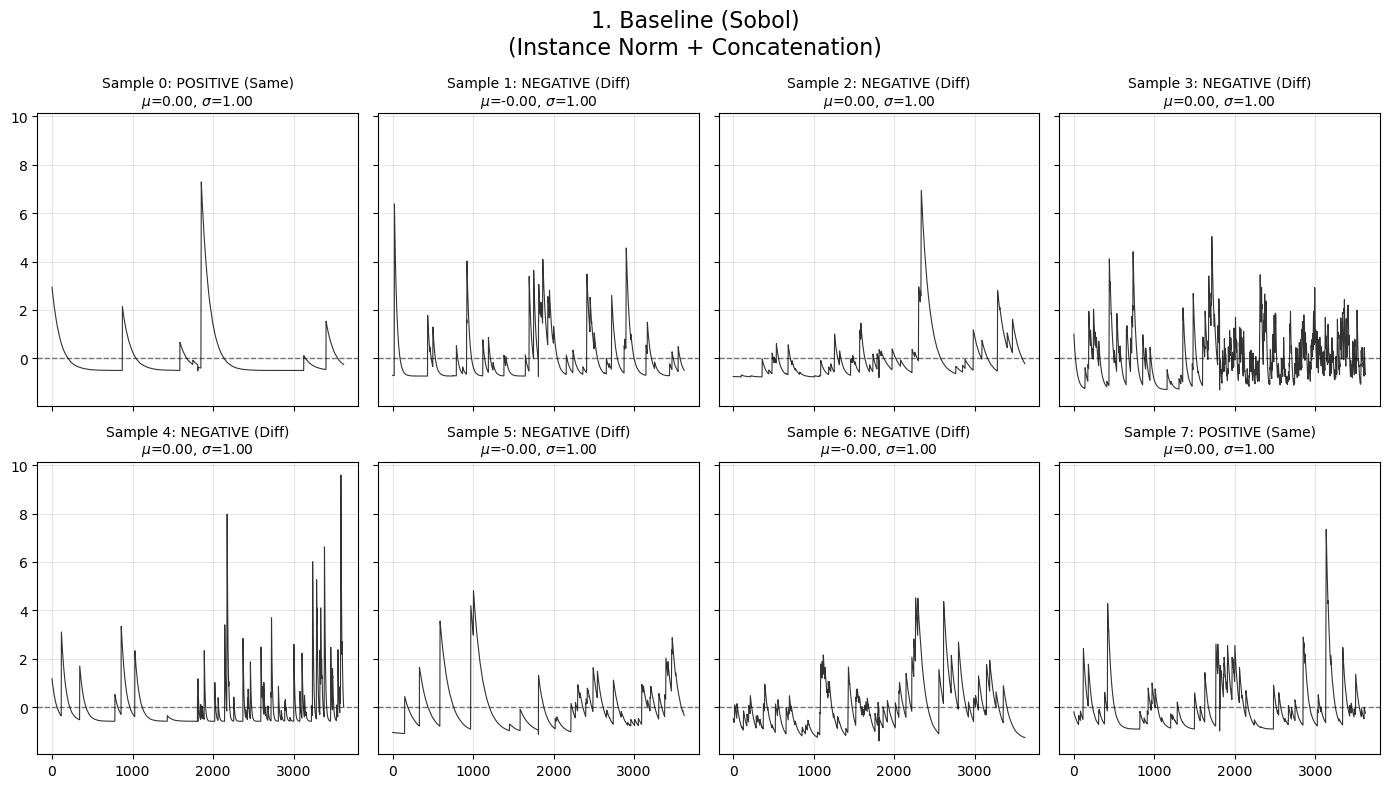

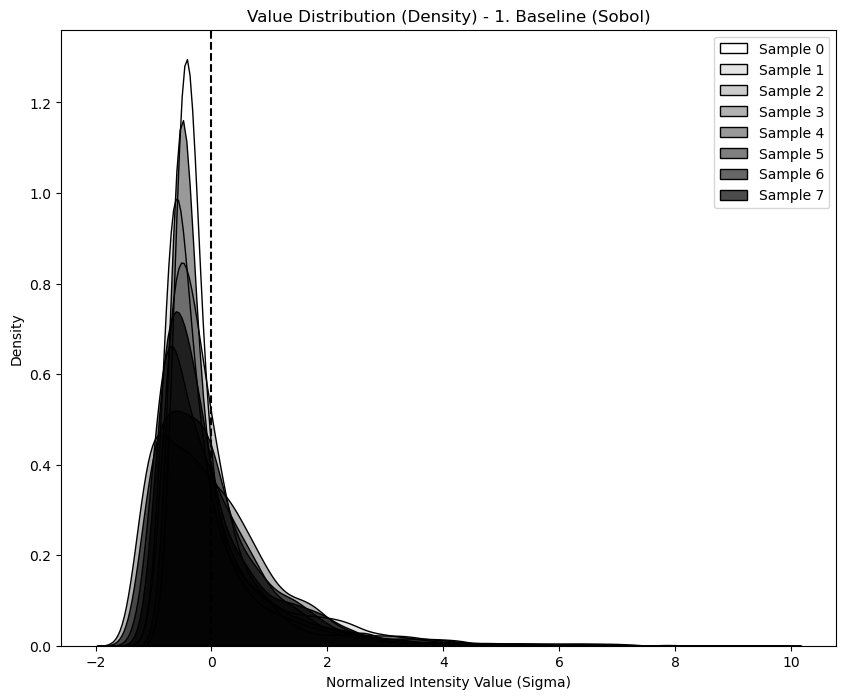

Loading data for 2. Mu Variation...
Files split: 655 Train, 164 Val, 205 Test
Generating 10 training groups...


 20%|██        | 2/10 [00:00<00:00, 13.33it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_921.881_1.000_50.000.npz
 B: mRNA_trajectories_78.997_1.000_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_798.031_1.000_50.000.npz
 B: mRNA_trajectories_355.192_1.000_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_252.381_1.000_50.000.npz
 B: mRNA_trajectories_745.696_1.000_50.000.npz


 40%|████      | 4/10 [00:00<00:00,  9.62it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_805.141_1.000_50.000.npz
 B: mRNA_trajectories_277.191_1.000_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_271.935_1.000_50.000.npz
 B: mRNA_trajectories_579.724_1.000_50.000.npz
Generating POSITIVE group.


 80%|████████  | 8/10 [00:00<00:00, 12.77it/s]

Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_559.983_1.000_50.000.npz
 B: mRNA_trajectories_235.772_1.000_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_949.337_1.000_50.000.npz
 B: mRNA_trajectories_405.606_1.000_50.000.npz


100%|██████████| 10/10 [00:00<00:00, 12.45it/s]


Generating POSITIVE group.
Generating validation groups...


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_978.714_1.000_50.000.npz
 B: mRNA_trajectories_348.400_1.000_50.000.npz
Generating test groups...


  0%|          | 0/1 [00:00<?, ?it/s]

Generating POSITIVE group.


100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


Batch Mean (should be ~0): -0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -1.31, Max Value: 9.33

=== Visualizing: 2. Mu Variation ===
Batch Shape: torch.Size([8, 5021, 1])
Batch Stats -> Mean: -0.0000 | Std: 0.9999 (Should be ~0.0 and ~1.0)


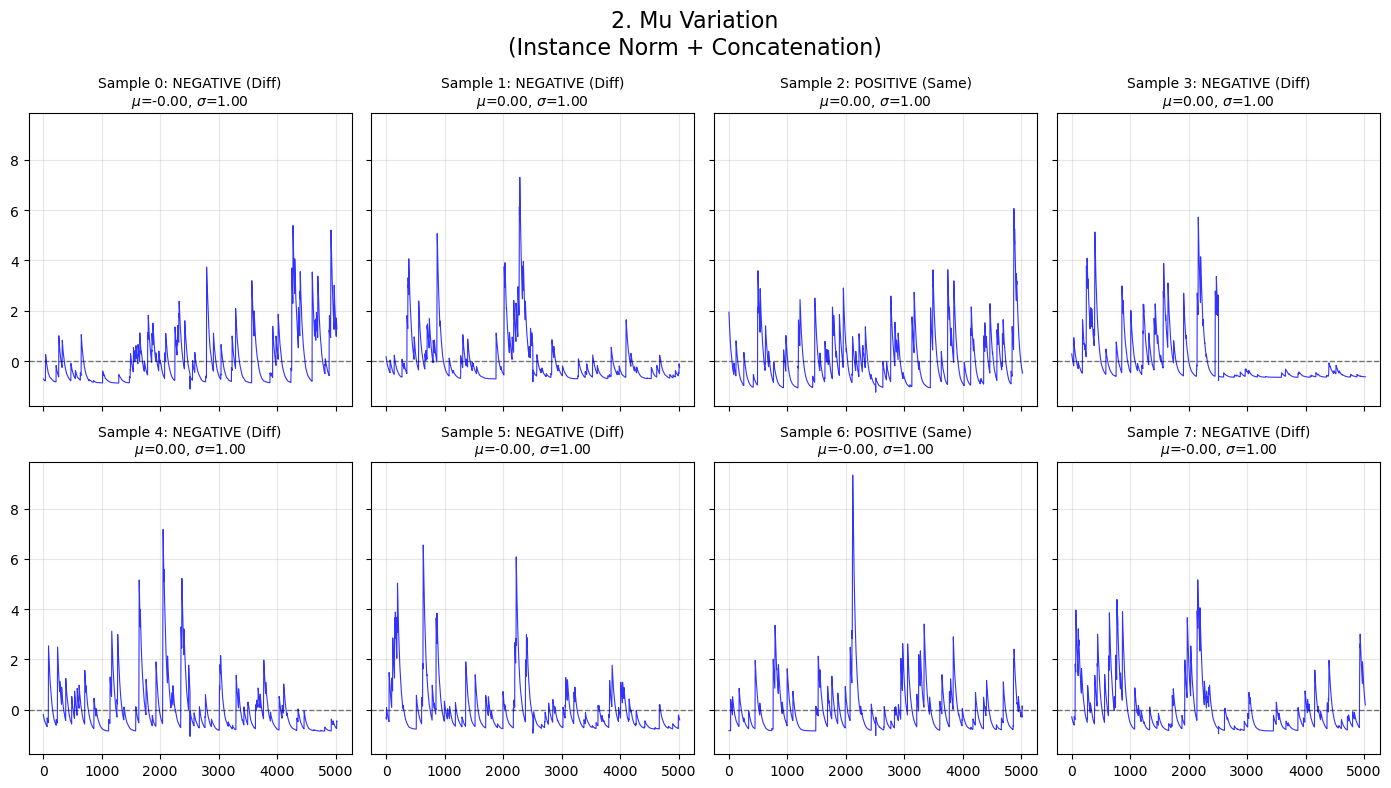

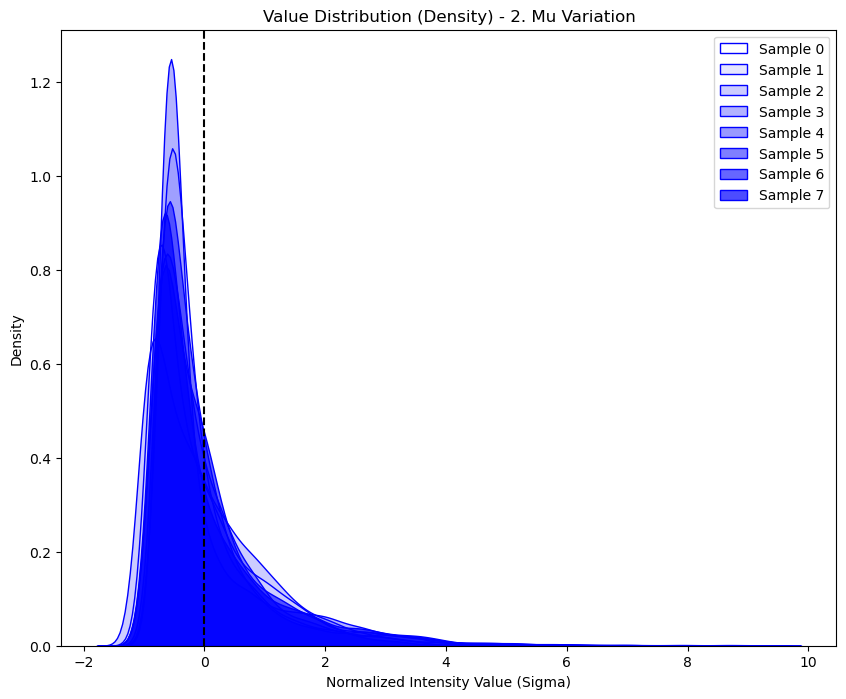

Loading data for 3. CV Variation...
Files split: 535 Train, 134 Val, 168 Test
Generating 10 training groups...


 30%|███       | 3/10 [00:00<00:00, 19.24it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.527_50.000.npz
 B: mRNA_trajectories_100.000_3.218_50.000.npz
Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.151_50.000.npz
 B: mRNA_trajectories_100.000_0.180_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.453_50.000.npz
 B: mRNA_trajectories_100.000_0.633_50.000.npz


 60%|██████    | 6/10 [00:00<00:00, 22.36it/s]

Generating POSITIVE group.
Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_3.258_50.000.npz
 B: mRNA_trajectories_100.000_1.050_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.672_50.000.npz
 B: mRNA_trajectories_100.000_0.398_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.620_50.000.npz
 B: mRNA_trajectories_100.000_0.374_50.000.npz


100%|██████████| 10/10 [00:00<00:00, 18.91it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.245_50.000.npz
 B: mRNA_trajectories_100.000_3.460_50.000.npz
Generating validation groups...


100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_3.173_50.000.npz
 B: mRNA_trajectories_100.000_0.935_50.000.npz
Generating test groups...


  0%|          | 0/1 [00:00<?, ?it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.471_50.000.npz
 B: mRNA_trajectories_100.000_0.630_50.000.npz


100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


Batch Mean (should be ~0): -0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -2.42, Max Value: 11.60

=== Visualizing: 3. CV Variation ===
Batch Shape: torch.Size([8, 5003, 1])
Batch Stats -> Mean: -0.0000 | Std: 0.9999 (Should be ~0.0 and ~1.0)


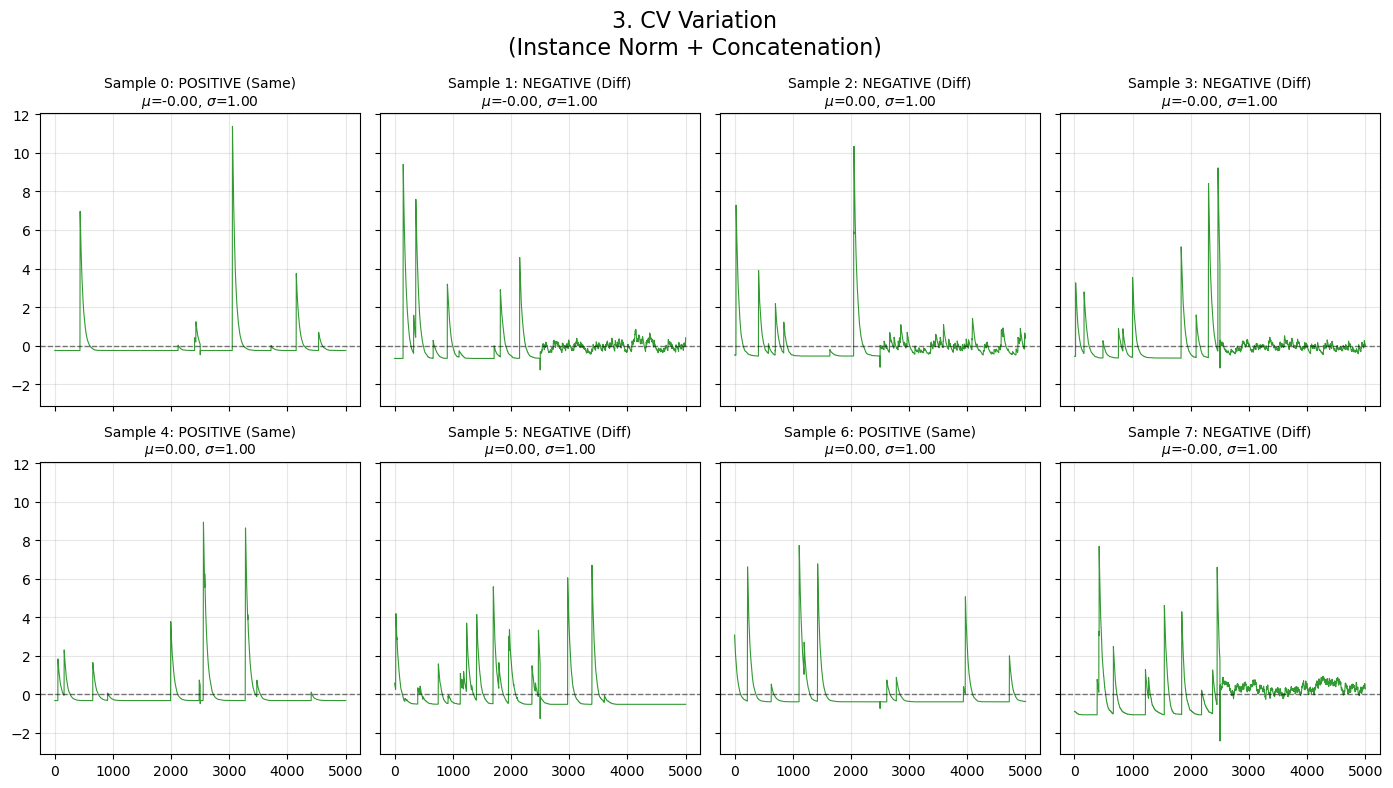

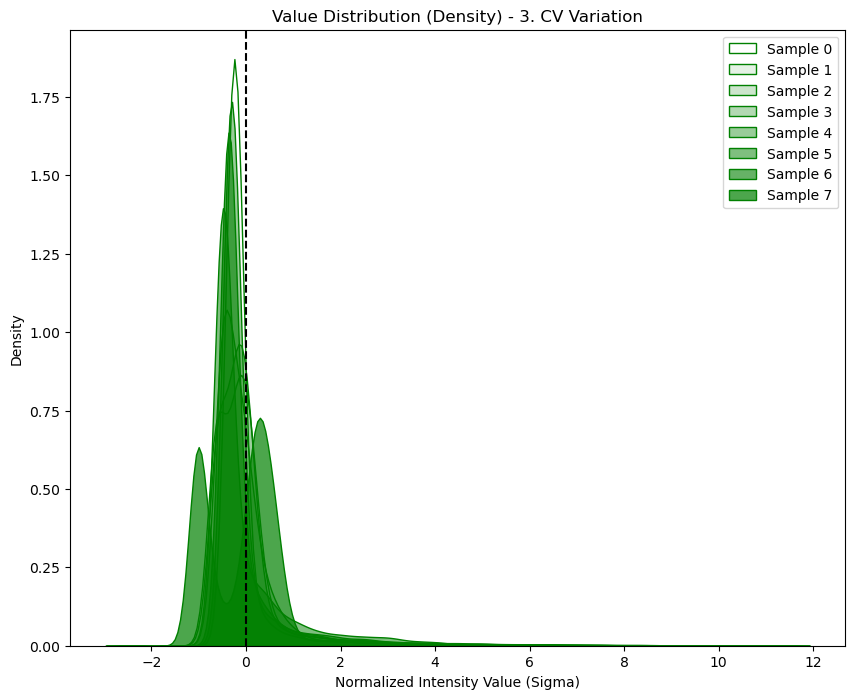

Loading data for 4. Tac Variation...
Files split: 655 Train, 164 Val, 205 Test
Generating 10 training groups...


 20%|██        | 2/10 [00:00<00:00, 14.98it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_92.504.npz
 B: mRNA_trajectories_100.000_1.000_11.621.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_80.619.npz
 B: mRNA_trajectories_100.000_1.000_38.124.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_28.259.npz
 B: mRNA_trajectories_100.000_1.000_75.597.npz


 60%|██████    | 6/10 [00:00<00:00, 15.21it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_81.301.npz
 B: mRNA_trajectories_100.000_1.000_30.640.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_30.135.npz
 B: mRNA_trajectories_100.000_1.000_74.493.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_37.170.npz
 B: mRNA_trajectories_100.000_1.000_11.621.npz
Generating POSITIVE group.


 80%|████████  | 8/10 [00:00<00:00, 15.81it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_78.457.npz
 B: mRNA_trajectories_100.000_1.000_26.665.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_95.138.npz
 B: mRNA_trajectories_100.000_1.000_42.962.npz
Generating POSITIVE group.


100%|██████████| 10/10 [00:00<00:00, 15.17it/s]


Generating validation groups...


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_97.957.npz
 B: mRNA_trajectories_100.000_1.000_37.473.npz
Generating test groups...


100%|██████████| 1/1 [00:00<00:00, 28.27it/s]


Generating POSITIVE group.
Batch Mean (should be ~0): 0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -2.46, Max Value: 6.60

=== Visualizing: 4. Tac Variation ===
Batch Shape: torch.Size([8, 4023, 1])
Batch Stats -> Mean: 0.0000 | Std: 0.9999 (Should be ~0.0 and ~1.0)


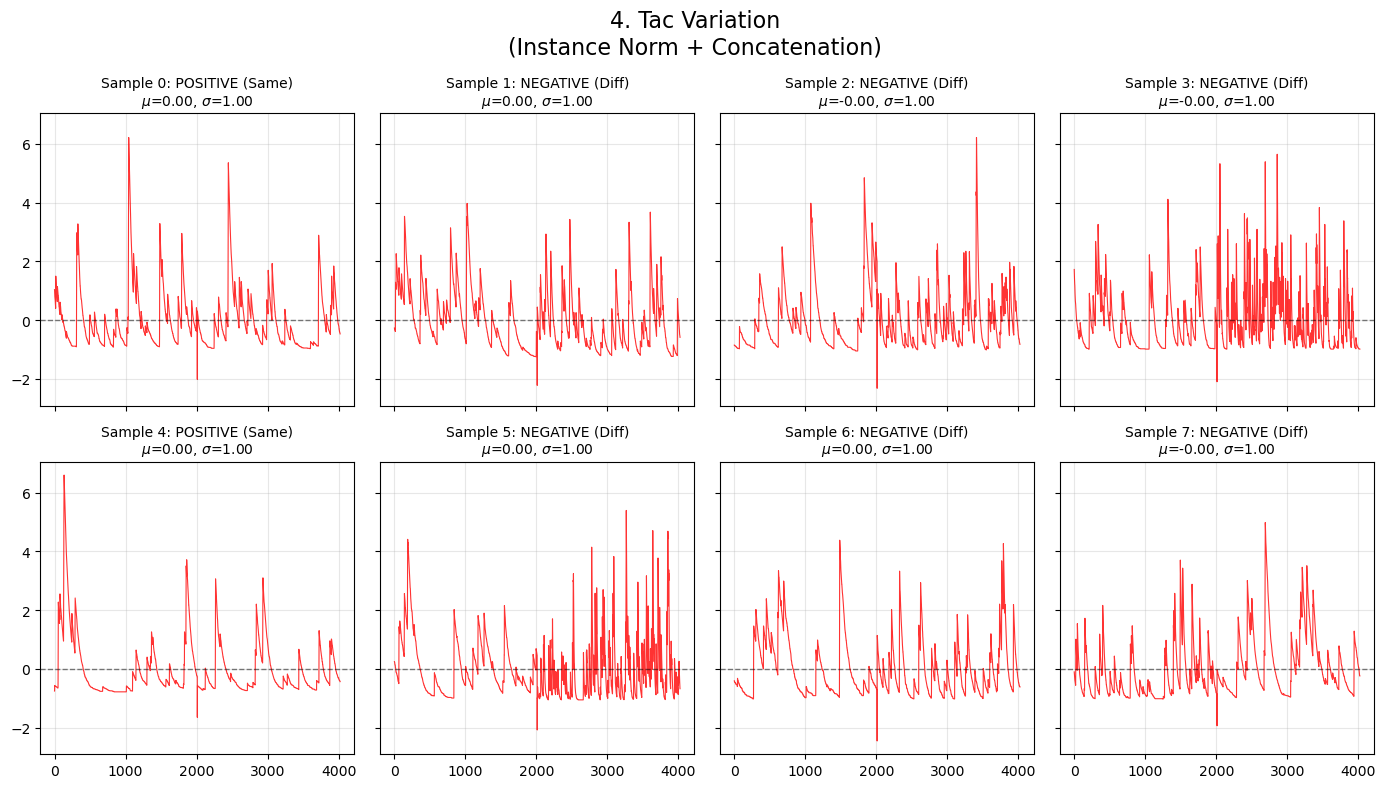

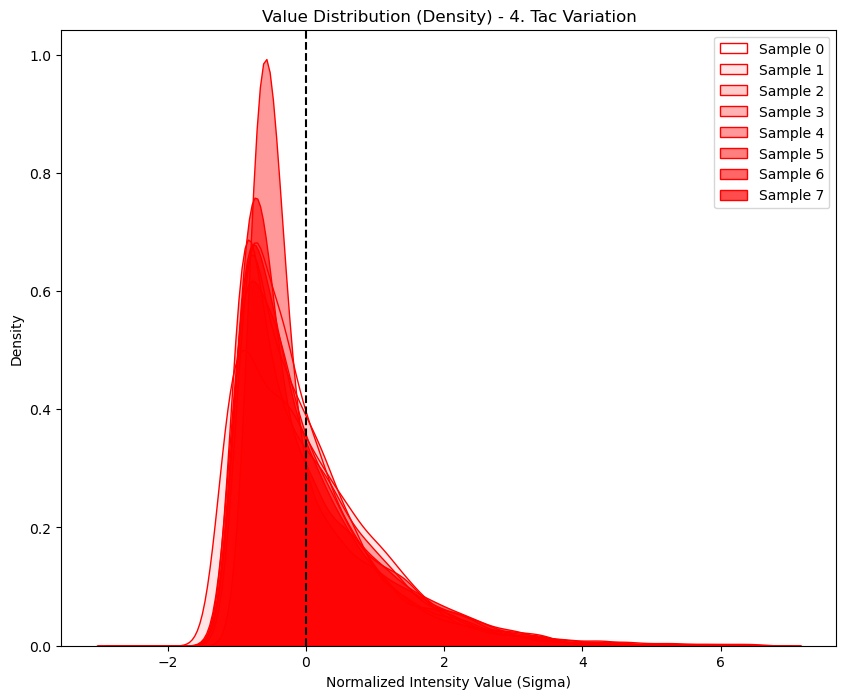

In [6]:
script_dir = Path.cwd()

for exp in EXPERIMENTS:
    data_root = script_dir / exp["data_dir"]
    results_path = data_root / exp["csv_name"]
    
    if not results_path.exists():
        print(f"❌ Skipping {exp['name']}: CSV not found at {results_path}")
        continue
        
    # Read parameters to get file lists
    try:
        df_params = pd.read_csv(results_path)
        # filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
        df_params = df_params[(df_params['success'] == True) & 
                            (df_params['error_message'].isna()) &
                            (df_params['mean_rel_error_pct'] < 10) & 
                            (df_params['cv_rel_error_pct'] < 10) & 
                            (df_params['t_ac_rel_error_pct'] < 10)]
        
        # Reconstruct file paths
        # Note: Adjust column name 'trajectory_filename' if your CSV uses a different one
        if 'trajectory_filename' in df_params.columns:
            traj_paths = [data_root / fname for fname in df_params['trajectory_filename'].values]
            traj_npz_paths = [p.with_suffix('.npz') for p in traj_paths]
        else:
            print(f"⚠️ Column 'trajectory_filename' not found in {exp['csv_name']}. Skipping.")
            continue
            
        # Initialize Loader using your function
        # We use a small num_groups just to get the loader ready
        print(f"Loading data for {exp['name']}...")
        train_loader, _, _, _ = baseline_data_prep(
            traj_npz_paths,
            batch_size=8,        # Small batch for visualization
            num_groups_train=10, # Minimal groups needed
            num_groups_val=1,
            num_groups_test=1,
            num_traj=2,        
            pos_ratio=0.5,
            verbose=True
        )
        
        # Visualize
        visualize_batch(train_loader, exp["name"], exp["color"])
        
    except Exception as e:
        print(f"❌ Error processing {exp['name']}: {e}")
        import traceback
        traceback.print_exc()

# compare SVM benchmarking scores vs transformer scores for each experiment

In [7]:
# from output logs of each experiment (IY011_baseline_model_training_5*.out)
# # t_ac experiment 
# test_acc_tac = 0.50 
# test_acc_tac_shuffled = 0.50
# svm_acc_tac = 0.50
# # mu experiment
# test_acc_mu = 0.76
# test_acc_mu_shuffled = 0.50
# svm_acc_mu = 0.76
# # cv experiment
# test_acc_cv = 0.51
# test_acc_cv_shuffled = 0.50
# svm_acc_cv = 0.57   
# ==================================
# from IY011_baseline_model_training_7*.out
# baseline experiment (all stats varying together)
test_acc = 0.82
test_acc_shuffled = 0.85
svm_acc = 0.77
# t_ac experiment 
test_acc_tac = 0.56 
test_acc_tac_shuffled = 0.49
svm_acc_tac = 0.48
# mu experiment
test_acc_mu = 1.00
test_acc_mu_shuffled = 1.00
svm_acc_mu = 1.00
# cv experiment
test_acc_cv = 0.95
test_acc_cv_shuffled = 0.97
svm_acc_cv = 0.49


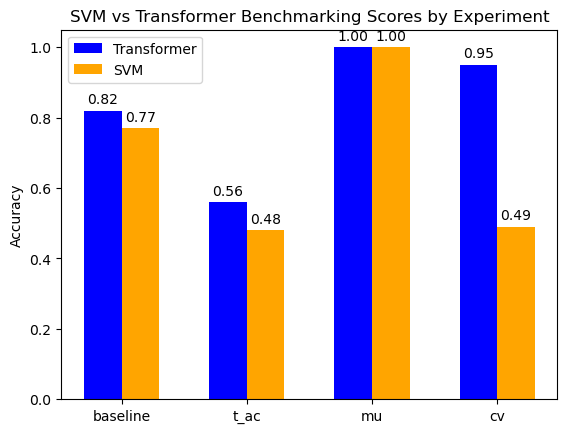

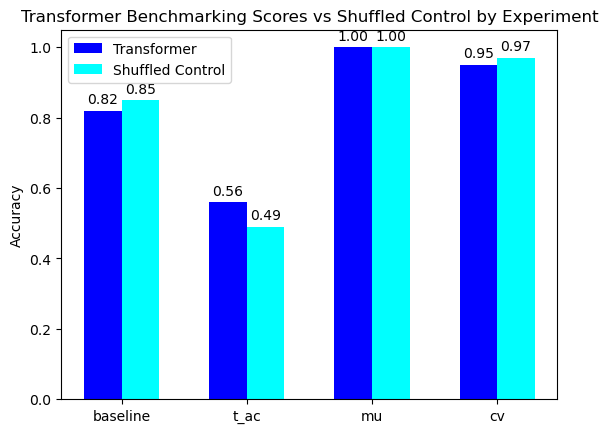

In [9]:
# plot results (transformer vs SVM)
labels = ['baseline','t_ac', 'mu', 'cv']
transformer_scores = [test_acc, test_acc_tac, test_acc_mu, test_acc_cv]
svm_scores = [svm_acc, svm_acc_tac, svm_acc_mu, svm_acc_cv]
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, transformer_scores, width, label='Transformer', color ='blue')
rects2 = ax.bar(x + width/2, svm_scores, width, label='SVM', color ='orange')
# Add value labels on top of bars
ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('SVM vs Transformer Benchmarking Scores by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend() 
plt.show()
# plot results showing shuffled control scores
shuffled_scores = [test_acc_shuffled, test_acc_tac_shuffled, test_acc_mu_shuffled, test_acc_cv_shuffled]
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, transformer_scores, width, label='Transformer', color='blue')
rects2 = ax.bar(x + width/2, shuffled_scores, width, label='Shuffled Control', color='cyan')
# Add value labels on top of bars
ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Transformer Benchmarking Scores vs Shuffled Control by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

## Investigate reason for low SVM score in cv experiment

In [ ]:
from utils.data_loader import load_loader_from_disk

BASELINE_DATA_ROOT = script_dir / "temp_data"
CV_DATA_ROOT = script_dir / "temp_data_cv_variation"
TAC_DATA_ROOT = script_dir / "temp_data_t_ac_variation"
MU_DATA_ROOT = script_dir / "temp_data_mu_variation"

baseline_train_save_path = BASELINE_DATA_ROOT / "static_train.pt"
baseline_val_save_path   = BASELINE_DATA_ROOT / "static_val.pt"
baseline_test_save_path  = BASELINE_DATA_ROOT / "static_test.pt"
baseline_train_loader = load_loader_from_disk(baseline_train_save_path)
baseline_val_loader = load_loader_from_disk(baseline_val_save_path)
baseline_test_loader = load_loader_from_disk(baseline_test_save_path)

cv_train_save_path = CV_DATA_ROOT / "static_train.pt"
cv_val_save_path   = CV_DATA_ROOT / "static_val.pt"
cv_test_save_path  = CV_DATA_ROOT / "static_test.pt"
cv_train_loader = load_loader_from_disk(cv_train_save_path)
cv_val_loader = load_loader_from_disk(cv_val_save_path)
cv_test_loader = load_loader_from_disk(cv_test_save_path)   

tac_train_save_path = TAC_DATA_ROOT / "static_train.pt"
tac_val_save_path   = TAC_DATA_ROOT / "static_val.pt"
tac_test_save_path  = TAC_DATA_ROOT / "static_test.pt"
tac_train_loader = load_loader_from_disk(tac_train_save_path)
tac_val_loader = load_loader_from_disk(tac_val_save_path)
tac_test_loader = load_loader_from_disk(tac_test_save_path)

mu_train_save_path = MU_DATA_ROOT / "static_train.pt"
mu_val_save_path   = MU_DATA_ROOT / "static_val.pt"
mu_test_save_path  = MU_DATA_ROOT / "static_test.pt"
mu_train_loader = load_loader_from_disk(mu_train_save_path)
mu_val_loader = load_loader_from_disk(mu_val_save_path)
mu_test_loader = load_loader_from_disk(mu_test_save_path)   

📂 Loading static data from /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/temp_data/static_train.pt...
📂 Loading static data from /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/temp_data/static_val.pt...
📂 Loading static data from /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/temp_data/static_test.pt...
📂 Loading static data from /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/temp_data_cv_variation/static_train.pt...
📂 Loading static data from /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/temp_data_cv_variation/static_val.pt...
📂 Loading static data from /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/temp_data_cv_variation/static_test.pt...
📂 Loading static data from /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/temp_data_t_ac_variation/static_train.pt...
📂 Loading static data from /home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/temp_data_t_ac_variation/static_val.p

In [25]:
# verify the results seen from training script
def extract_data_for_svm(loader):
    """
    Extracts all batches from a DataLoader and flattens them for SVM input.
    Input X: (Batch, Time, Features) -> Output X: (Total_Samples, Time * Features)
    """
    X_list = []
    y_list = []
    
    print(f"Extracting data from loader for SVM...")
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            # Move to CPU and convert to numpy
            X_np = X_batch.cpu().numpy()
            y_np = y_batch.cpu().numpy()
            
            # Flatten the time series: 
            # (Batch, Seq_Len, 1) -> (Batch, Seq_Len)
            # This turns the time series into a long feature vector
            X_flat = X_np.reshape(X_np.shape[0], -1)
            
            X_list.append(X_flat)
            y_list.append(y_np)
            
    # Concatenate all batches
    return np.vstack(X_list), np.concatenate(y_list)


# 1. Extract Data dynamically from your loaders
X_train_svm, y_train_svm = extract_data_for_svm(baseline_train_loader)
X_test_svm, y_test_svm   = extract_data_for_svm(baseline_test_loader)

print(f"SVM Train Shape: {X_train_svm.shape}")
print(f"SVM Test Shape:  {X_test_svm.shape}")
from classifiers.svm_classifier import svm_classifier
# 2. Run the SVM Classifier
svm_accuracy = svm_classifier(
    X_train_svm,
    X_test_svm,
    y_train_svm,
    y_test_svm,
)

Extracting data from loader for SVM...
Extracting data from loader for SVM...
SVM Train Shape: (3000, 3641)
SVM Test Shape:  (600, 3641)


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== SVM (RBF Kernel) Classification Accuracy: 0.77 ===


Dataset: Baseline
Extracting data for visualization...
Analyzing (3000, 3641) samples...
Running PCA...
Running t-SNE (this might take a moment)...
Training Diagnostic SVM...
Extracting data from loader for SVM...


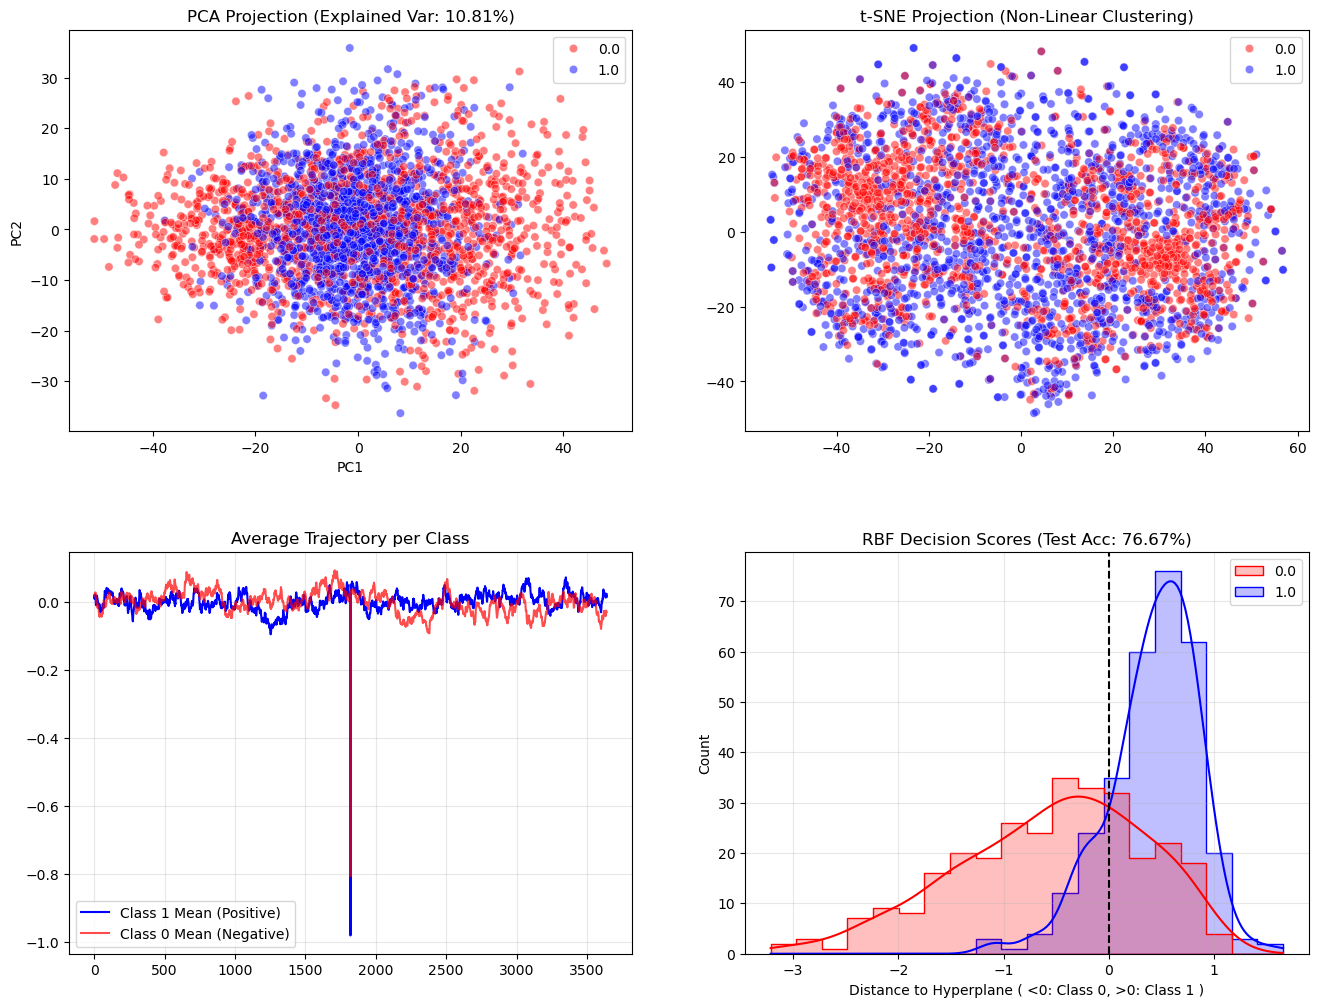

Dataset: TAC Variation
Extracting data for visualization...
Analyzing (3000, 3633) samples...
Running PCA...
Running t-SNE (this might take a moment)...
Training Diagnostic SVM...
Extracting data from loader for SVM...


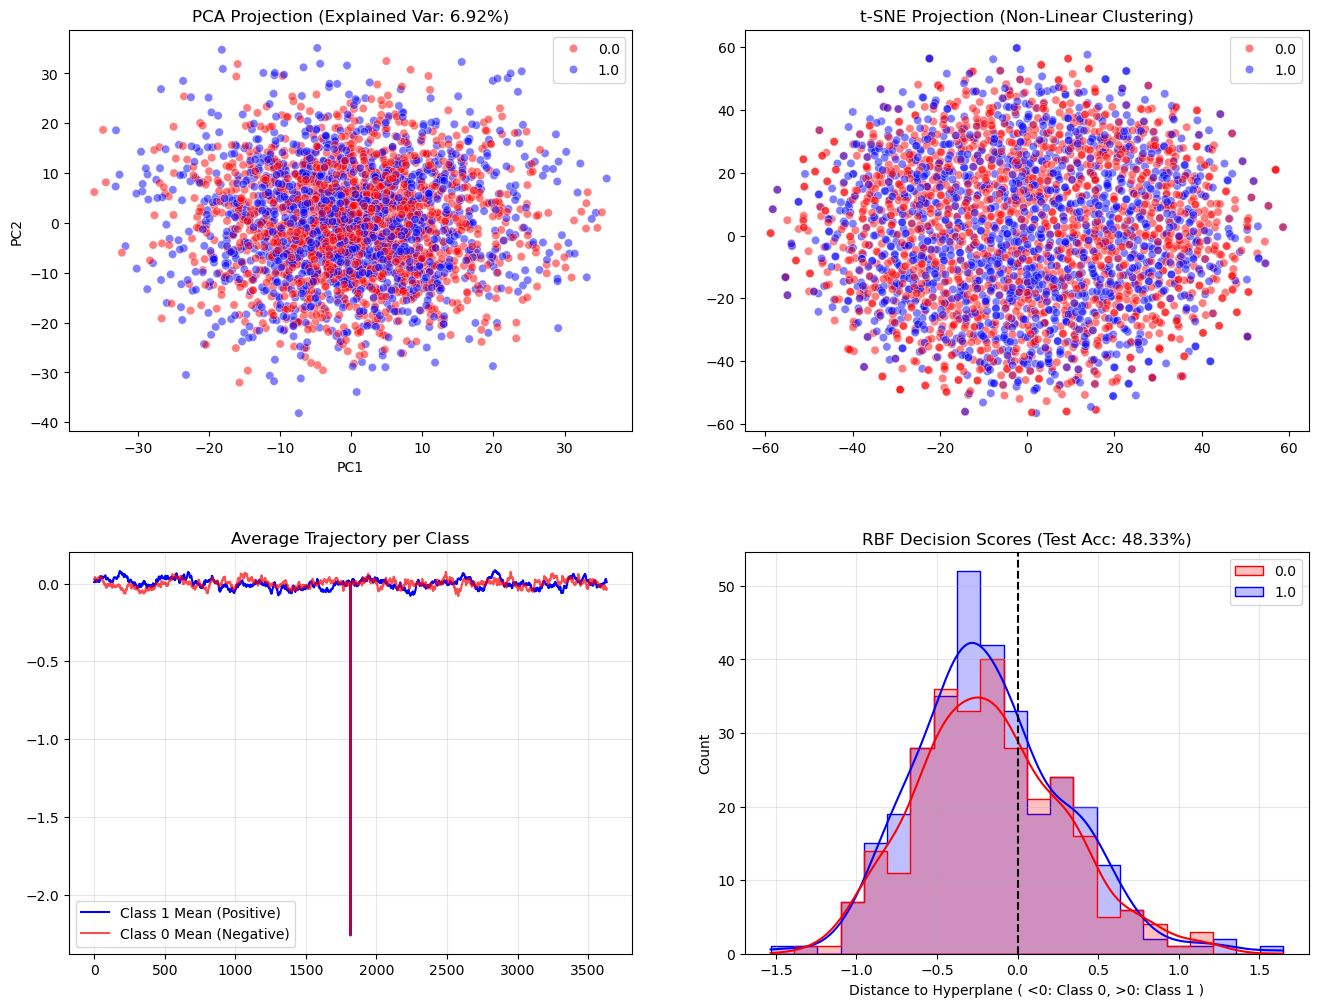

Dataset: MU Variation
Extracting data for visualization...
Analyzing (3000, 5823) samples...
Running PCA...
Running t-SNE (this might take a moment)...
Training Diagnostic SVM...
Extracting data from loader for SVM...


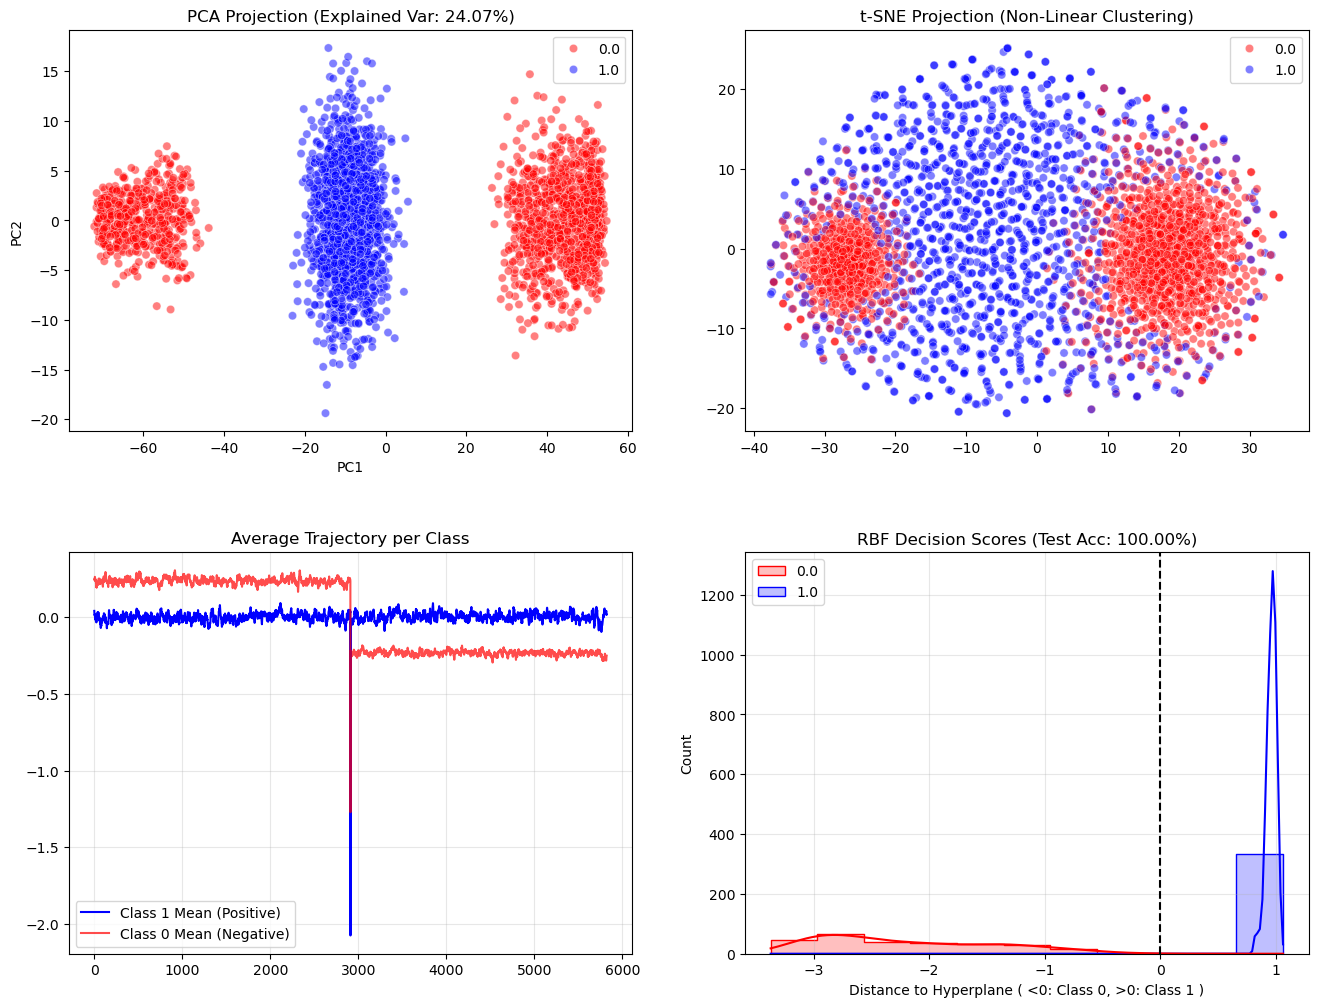

Dataset: CV Variation
Extracting data for visualization...
Analyzing (3000, 5823) samples...
Running PCA...
Running t-SNE (this might take a moment)...
Training Diagnostic SVM...
Extracting data from loader for SVM...


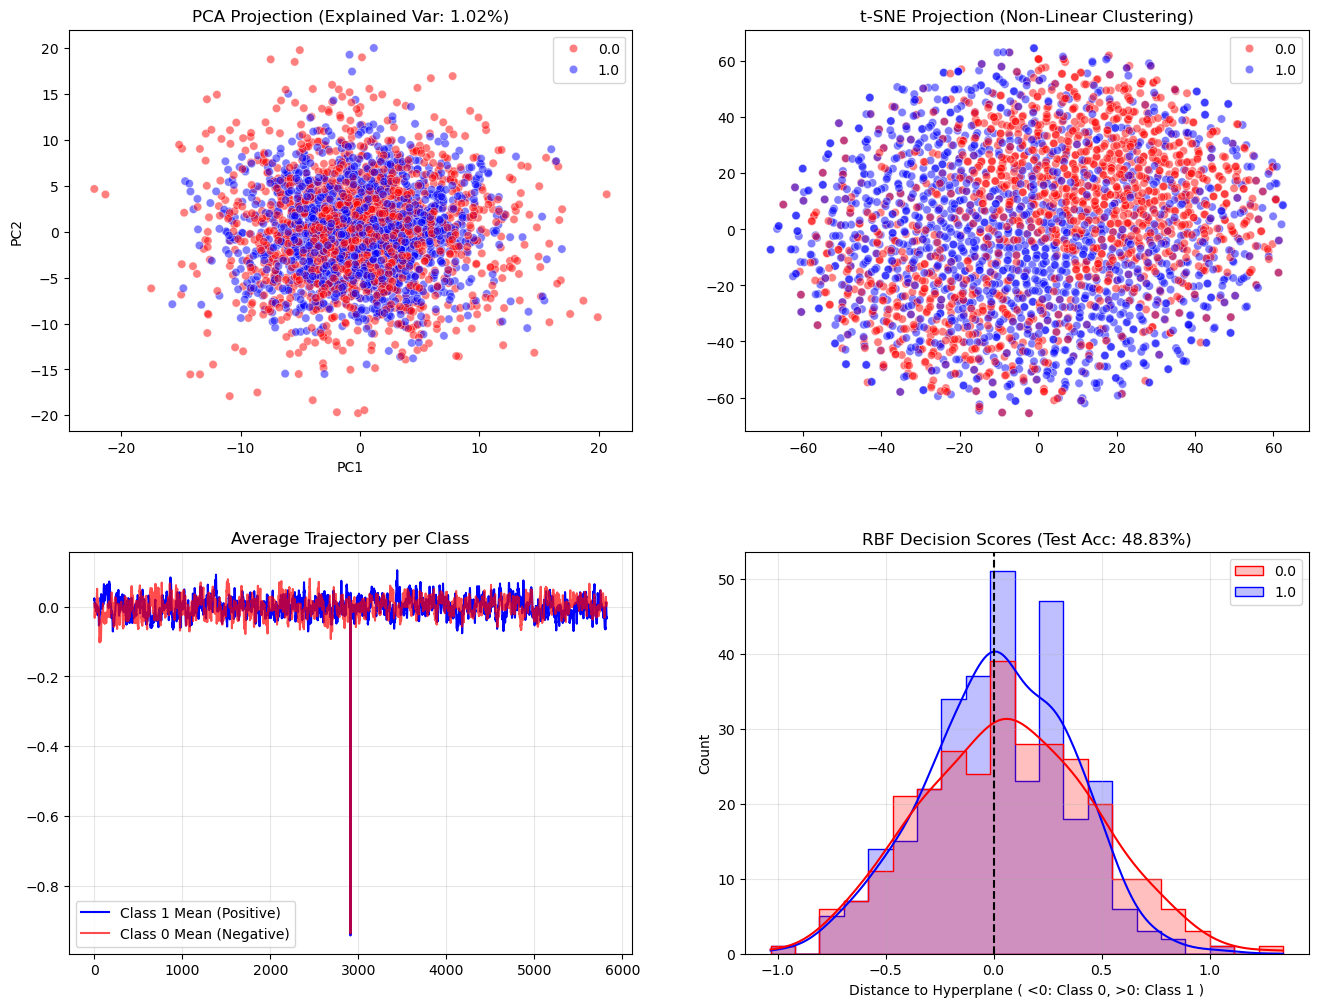

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
import torch

def visualize_svm_learning(train_loader, test_loader, max_samples=3000):
    """
    Diagnoses why an SVM might be failing by visualizing the data geometry
    and linear decision boundaries.
    """
    print("Extracting data for visualization...")
    
    # 1. Collect Data from Loader
    X_list, y_list = [], []
    count = 0
    
    for X, y in train_loader:
        # X shape: (Batch, Time, 1) -> Flatten to (Batch, Time)
        X_flat = X.squeeze().cpu().numpy()
        y_flat = y.squeeze().cpu().numpy()
        
        X_list.append(X_flat)
        y_list.append(y_flat)
        
        count += X.shape[0]
        if count >= max_samples: break
            
    X_all = np.concatenate(X_list, axis=0)[:max_samples]
    y_all = np.concatenate(y_list, axis=0)[:max_samples]
    
    print(f"Analyzing {X_all.shape} samples...")

    # Set up plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3)

    # --- Plot A: PCA Projection (Global Variance) ---
    print("Running PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_all)
    
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_all, palette={0:'red', 1:'blue'}, alpha=0.5, ax=axes[0,0])
    axes[0,0].set_title(f"PCA Projection (Explained Var: {pca.explained_variance_ratio_.sum():.2%})")
    axes[0,0].set_xlabel("PC1")
    axes[0,0].set_ylabel("PC2")

    # --- Plot B: t-SNE Projection (Local Manifold) ---
    print("Running t-SNE (this might take a moment)...")
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
    X_tsne = tsne.fit_transform(X_all)
    
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_all, palette={0:'red', 1:'blue'}, alpha=0.5, ax=axes[0,1])
    axes[0,1].set_title("t-SNE Projection (Non-Linear Clustering)")

    # --- Plot C: Average Profiles ---
    # SVMs often rely on the mean difference between classes.
    # If these look identical, a linear SVM has nothing to work with.
    mean_pos = X_all[y_all==1].mean(axis=0)
    mean_neg = X_all[y_all==0].mean(axis=0)
    
    axes[1,0].plot(mean_pos, color='blue', label='Class 1 Mean (Positive)')
    axes[1,0].plot(mean_neg, color='red', label='Class 0 Mean (Negative)', alpha=0.7)
    axes[1,0].set_title("Average Trajectory per Class")
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # --- Plot D: Linear SVM Weights (Feature Importance) ---
    # We train a quick SVM to see what it *tries* to learn.
    print("Training Diagnostic SVM...")
    svm = SVC(C=1.0, gamma='scale', kernel='rbf')
    svm.fit(X_all, y_all)
    
    # Get the "Distance to boundary" for every point
    X_test_svm, y_test_svm = extract_data_for_svm(test_loader)
    scores = svm.decision_function(X_test_svm)
    acc = accuracy_score(y_test_svm, svm.predict(X_test_svm))

    # Plot Histogram of scores
    sns.histplot(x=scores, hue=y_test_svm.flatten(), palette={0:'red', 1:'blue'}, kde=True, element="step", ax=axes[1,1])
    axes[1,1].set_title(f"RBF Decision Scores (Test Acc: {acc:.2%})")
    axes[1,1].set_xlabel("Distance to Hyperplane ( <0: Class 0, >0: Class 1 )")
    axes[1,1].axvline(0, color='black', linestyle='--') # Decision Boundary
    axes[1,1].grid(True, alpha=0.3)
    
    plt.show()
    
    # weights = svm.coef_.flatten()
    # axes[1,1].plot(weights, color='purple')
    # axes[1,1].set_title("Linear SVM Weights (What time points matter?)")
    # axes[1,1].set_xlabel("Time Step")
    # axes[1,1].set_ylabel("Weight Magnitude")
    # axes[1,1].grid(True, alpha=0.3)
    
    # plt.show()

# === Usage ===
print('Dataset: Baseline')
visualize_svm_learning(baseline_train_loader, baseline_test_loader)
print('Dataset: TAC Variation')
visualize_svm_learning(tac_train_loader, tac_test_loader)
print('Dataset: MU Variation')
visualize_svm_learning(mu_train_loader, mu_test_loader)
print('Dataset: CV Variation')
visualize_svm_learning(cv_train_loader, cv_test_loader)